## An example on how to integrate a 1D scalar function

This notebook shows examples on how to use the present gaussian process regression framework to formally integrate functions from derivative observations.

This example will show how to predict a 1D function both with a full GPR and a sparse GPR. The sparse GPR framework works by projecting the training data into a lower dimensional feature space in order to reduce the computational cost (mainly matrix inversions).

### Creating the training data set

`jax.numpy` has almost the same usage as the standard `numpy` package, with the caveat that `jax.ndarray` is an immutable type, meaning that no inplace changes can be made. For creating training data this should however not be an issue.

In [40]:
import jax.numpy as jnp
from jax import random

We will model a simple sin function:

In [41]:
# true function is a noisy lennard jones potential
def sin(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.sin(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

def cos(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.cos(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

To define the training data we first need to define boundaries to choose the datapoints from. Then, random points are chosen in this interval. `random.split` creates a new subkey from the previous key to get a new sudo-random sample from the uniform distribution.

In [42]:
# Interval bounds from which to choose the data points
bounds = jnp.array([0.0, 2*jnp.pi])

# How many function and derivative observations should be chosen
num_f_vals = (1,)
num_d_vals = (10,)

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, num_f_vals, minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, num_d_vals, minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.05
key, subkey = random.split(key)
y_func = sin(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = cos(x_der, noise, subkey)

The GPR framework needs as input for training a list of arrays `X_split` of length $N + 1$ where $N$ is the dimension of the input feature. Each array in `X_split` is of shape `(n_samples_i, N)`. `X_split` should be ordered as follows: the first array represents the datapoints for the function observations and the $N$ following arrays each represent the partial derivatives of the function with respect to each of the inputs in order. `Y_train` should just be an array of shape `(sum(n_samples_i),)`.

In our case $N=1$

In [43]:
# reshaping needs to be done the get the arrays in the form (n_samples_i, N)
X_split = [x_func.reshape(-1,1),x_der.reshape(-1,1)]

Y_train = jnp.hstack((y_func, y_der))

The kernels can be found in `jaxgp.kernels`. Currently implemented are `RBF`, `Linear`, and `Periodic` kernels. When in doubt what kernel to use, go with an `RBF` kernel.

In [44]:
from jaxgp.kernels import RBF

kernel = RBF()
# an RBF kernel has per default 2 parameters
init_kernel_params = (1.0, 1.0)

The regression models can be found in `jaxgp.regression`. The `ExactGPR` model takes as inital arguments a kernel to use, initial parameters for the kernel and a noise parameter that underlies the noisy datageneration.

In [45]:
from jaxgp.regression import ExactGPR

model = ExactGPR(kernel, init_kernel_params, noise)

Now there are 2 steps to get a fit function from the model.

 1. Fitting the model to the training data

In [46]:
model.train(X_split, Y_train)

OptStep(params=DeviceArray([1.1175048, 2.0138376], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-6.0965557, dtype=float32, weak_type=True), success=True, status=0, iter_num=7))


 2. Using the model to predict function values at new points

In [47]:
predict_grid = jnp.linspace(*bounds, 200)

# model.eval returns a mean prediction and a confidence interval around the mean prediction
means, stds = model.eval(predict_grid)

Plotting the predicted function together with its confidence interval we can see that even with only a few datapoints the prediction works good.

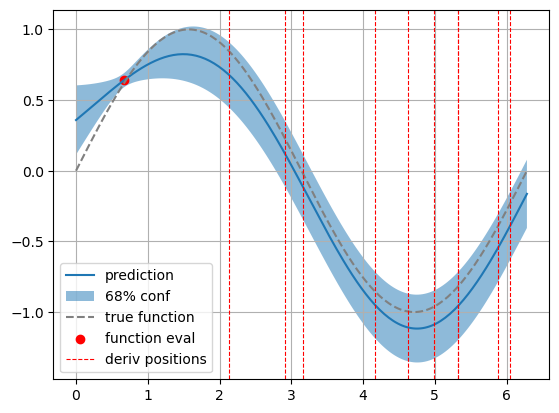

In [50]:
import matplotlib.pyplot as plt

plt.plot(predict_grid, means, label="prediction")
plt.fill_between(predict_grid, means-stds, means+stds, alpha=0.5, label="68% conf")

plt.plot(predict_grid, sin(predict_grid), c="gray", ls="--",label="true function")

plt.scatter(x_func, y_func, c="r", label="function eval")
for i,x in enumerate(x_der): 
    if i == 0:
        plt.axvline(x, c="r", lw=0.8, ls="--", label="deriv positions")
    else:
        plt.axvline(x, c="r", lw=0.8, ls="--")

plt.grid()
plt.legend()